# Финальное задание по Deep Learning Basic

In [69]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torchinfo import summary

import warnings

warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

from IPython.display import clear_output

import torchmetrics

In [70]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz0123456789"

SYMBOL_TO_IDX = {}
IDX_TO_SYMBOL = {}

for i, symbol in enumerate(ALPHABET):
    SYMBOL_TO_IDX[symbol] = i
    IDX_TO_SYMBOL[i] = symbol

MAXLEN = 5

PATH = "./samples"

IMAGE_SIZE = (32, 100)
BATCH_SIZE = 4
TEST_SIZE = 0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

## Подготовка данных.

In [71]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path: str, transform=None):
        self.path = path
        self.transform = transform

        self.data = []

        for dirs, folder, filenames in os.walk(path):
            for filename in filenames:
                self.data.append((filename, filename[:-4]))

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> (torch.Tensor, torch.Tensor):
        image_path, label = self.data[idx]
        image = Image.open(os.path.join(self.path, image_path))

        if self.transform:
            image = self.transform(image)
        else:
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)

        onehot = torch.zeros((MAXLEN, len(ALPHABET)))

        for i, symbol in enumerate(label):
            onehot[i][SYMBOL_TO_IDX[symbol]] = 1

        return image, onehot

In [72]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

In [73]:
dataset = ImageDataset(PATH, transform=transform)

dataset_size = len(dataset)

indices = torch.randint(dataset_size - 1, (dataset_size,))

split = int(np.floor(TEST_SIZE * dataset_size))

train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [74]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler
)

test_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler
)

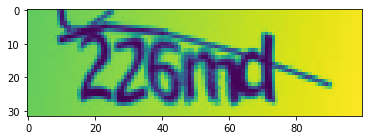

In [75]:
plt.imshow(dataset[0][0].permute(1, 2, 0));

## Создание и обучение модели.

### Модель (CRNN).

In [76]:
class ConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        use_batchnorm=False,
        use_maxpooling=False,
        pool_params=(2, 2),
        conv_params=(3, 1, 1),
    ):
        super().__init__()
        layers = [
            torch.nn.Conv2d(in_channels, out_channels, *conv_params),
            torch.nn.ReLU(),
        ]

        if use_batchnorm:
            layers.append(torch.nn.BatchNorm2d(out_channels))

        if use_maxpooling:
            layers.append(torch.nn.MaxPool2d(*pool_params))

        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.layers(x)
        return output

In [77]:
class BidirectionalLSTM(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()

        self.rnn = torch.nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.embedding = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.rnn.flatten_parameters()

        recurrent, _ = self.rnn(x)

        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)
        output = output.view(T, b, -1)

        return output

In [78]:
class CRNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        conv_layers = []
        conv_layers.append(ConvBlock(1, 64, use_maxpooling=True))
        conv_layers.append(ConvBlock(64, 128, use_maxpooling=True))
        conv_layers.append(ConvBlock(128, 256))
        conv_layers.append(
            ConvBlock(256, 256, use_maxpooling=True, pool_params=((1, 2), 2))
        )
        conv_layers.append(ConvBlock(256, 512, use_batchnorm=True))
        conv_layers.append(
            ConvBlock(
                512,
                512,
                use_batchnorm=True,
                use_maxpooling=True,
                pool_params=((1, 2), 2),
            )
        )
        conv_layers.append(ConvBlock(512, 512, conv_params=(2, 1, 0)))

        self.cnn = torch.nn.Sequential(*conv_layers)

        rnn_layers = []
        rnn_layers.append(BidirectionalLSTM(512, 256, 256))
        rnn_layers.append(BidirectionalLSTM(256, 256, len(ALPHABET)))

        self.rnn = torch.nn.Sequential(*rnn_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv_output = self.cnn(x)
        b, c, h, w = conv_output.shape

        conv_output = conv_output.reshape(b, -1, w)
        conv_output = conv_output.permute(2, 0, 1)

        rnn_output = self.rnn(conv_output)
        output = rnn_output.transpose(1, 0)

        for i in range(output.shape[0]):
            output[i] = F.log_softmax(output[i], dim=-1)

        return output

In [79]:
summary(CRNN(), (1, 1, 32, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [1, 5, 36]                --
├─Sequential: 1-1                        [1, 512, 1, 5]            --
│    └─ConvBlock: 2-1                    [1, 64, 16, 50]           --
│    │    └─Sequential: 3-1              [1, 64, 16, 50]           640
│    └─ConvBlock: 2-2                    [1, 128, 8, 25]           --
│    │    └─Sequential: 3-2              [1, 128, 8, 25]           73,856
│    └─ConvBlock: 2-3                    [1, 256, 8, 25]           --
│    │    └─Sequential: 3-3              [1, 256, 8, 25]           295,168
│    └─ConvBlock: 2-4                    [1, 256, 4, 12]           --
│    │    └─Sequential: 3-4              [1, 256, 4, 12]           590,080
│    └─ConvBlock: 2-5                    [1, 512, 4, 12]           --
│    │    └─Sequential: 3-5              [1, 512, 4, 12]           1,181,184
│    └─ConvBlock: 2-6                    [1, 512, 2, 6]        

### Обучение.

In [80]:
net = CRNN()
net = net.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [81]:
def set_seed(seed=42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)


def decode(x: torch.Tensor) -> list[str]:
    names = []

    for i in range(len(x)):
        name = ""
        indices = torch.argmax(x[i], dim=1)

        for idx in indices:
            name += IDX_TO_SYMBOL[idx.item()]

        names.append(name)

    return names


def character_error_rate(
    predictions: torch.Tensor, labels: torch.Tensor
) -> float:
    y_pred = decode(predictions)
    y_true = decode(labels)
    metric = torchmetrics.CharErrorRate()
    return metric(y_pred, y_true)


def plot_predictions(
    dataloader: torch.utils.data.DataLoader, net: torch.nn.Module, title: str
) -> None:
    net.eval()

    images, _ = next(iter(dataloader))
    images = images.to(DEVICE)

    predictions = net(images)
    test_names = decode(predictions)

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    for i in range(predictions.shape[0]):
        plt.subplot(predictions.shape[0] // 2, 2, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(test_names[i])

    plt.show()

In [82]:
def run_inference(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn,
    opt_fn: torch.optim,
    metric=character_error_rate,
    device=DEVICE,
    training=True,
) -> (float, float):

    if training:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_metric = 0.0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        if training:
            opt_fn.zero_grad()

        predictions = model(images)

        loss = loss_fn(predictions, labels)

        running_loss += loss.item()

        if training:
            loss.backward()
            opt_fn.step()

        running_metric += metric(predictions, labels)

    epoch_loss = running_loss / len(dataloader)
    epoch_metric = running_metric / len(dataloader)

    return epoch_loss, epoch_metric

In [83]:
def train(
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn,
    opt_fn: torch.optim,
    metric=character_error_rate,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    plot_examples=True,
) -> None:

    print(f"Training on {DEVICE}...")
    set_seed()

    for epoch in range(num_epochs):
        start = time.time()

        epoch_train_loss, epoch_train_metric = run_inference(
            dataloader=train_loader,
            model=model,
            loss_fn=loss_fn,
            opt_fn=opt_fn,
            metric=metric,
            device=device,
            training=True,
        )

        if plot_examples:
            plot_predictions(train_loader, net, "Train examples")

        epoch_test_loss, epoch_test_metric = run_inference(
            dataloader=test_loader,
            model=model,
            loss_fn=loss_fn,
            opt_fn=opt_fn,
            metric=metric,
            device=device,
            training=False,
        )

        if plot_examples:
            plot_predictions(test_loader, net, "Test examples")

        print(
            f"\nEpoch №{epoch + 1} | "
            f"Train loss: {epoch_train_loss:.4f} | "
            f"Test loss: {epoch_test_loss:.4f} | "
            f"Train CER: {epoch_train_metric:.4f} | "
            f"Test CER: {epoch_test_metric:.4f} | "
            f"Time: {time.time() - start:.4f} seconds"
        )

        clear_output(wait=True)

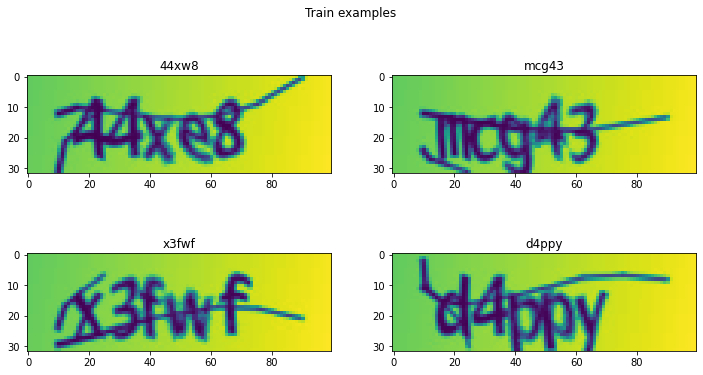

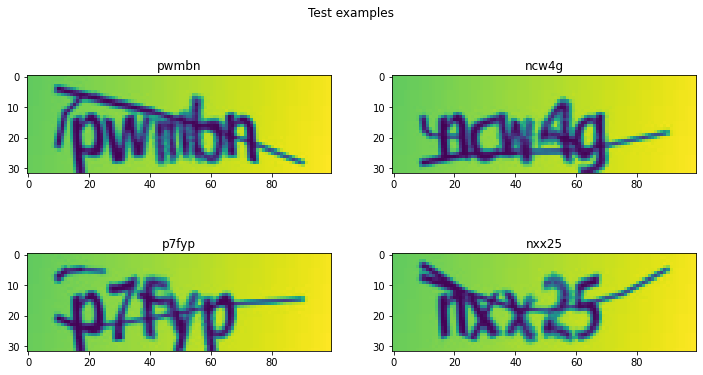


Epoch №50 | Train loss: 0.0189 | Test loss: 0.0238 | Train CER: 0.0119 | Test CER: 0.0306 | Time: 5.2130 seconds


In [84]:
train(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    model=net,
    loss_fn=criterion,
    opt_fn=optimizer,
    metric=character_error_rate,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
)

## Анализ ошибок.

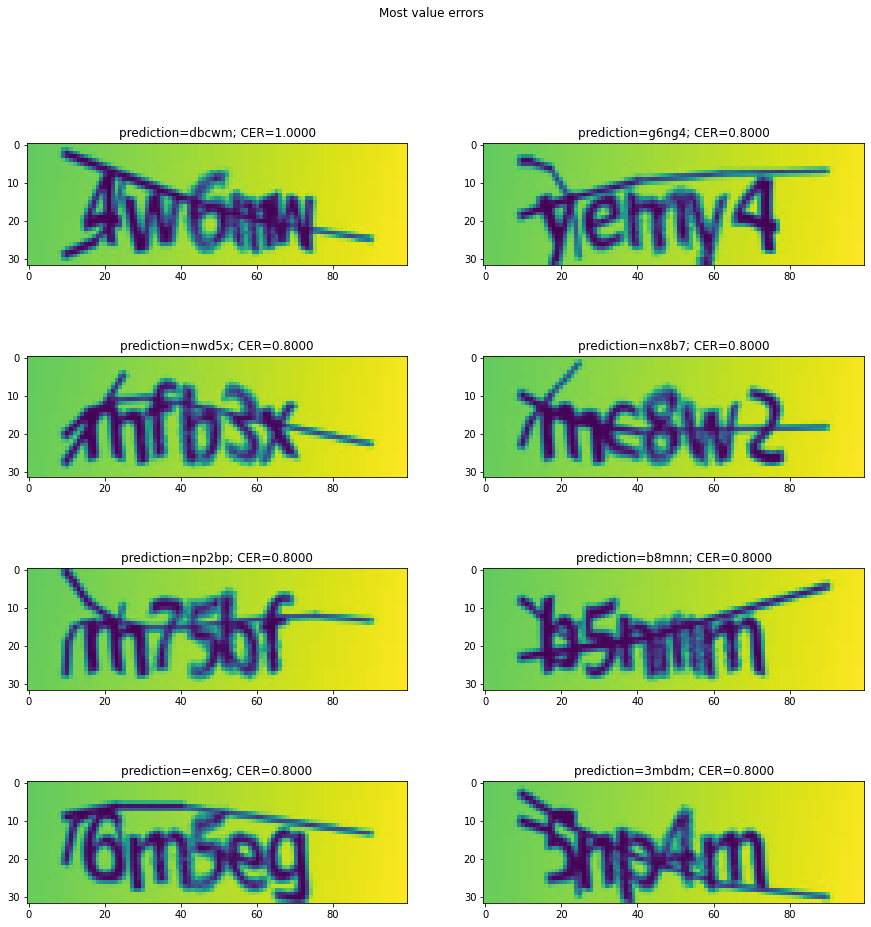

In [17]:
errors = []

for i, (image, label) in enumerate(dataset):
    image = image.to(DEVICE)
    image = torch.unsqueeze(image, 0)
    label = torch.unsqueeze(label, 0)

    prediction = net(image).detach().cpu()
    metric = character_error_rate(prediction, label).item()
    errors.append((metric, i, prediction[0]))

plot_number = 1

plt.figure(figsize=(15, 15))
plt.suptitle("Most value errors")

for error, i, prediction in sorted(errors, reverse=True)[:8]:
    image, label = dataset[i]
    prediction = torch.unsqueeze(prediction, 0)

    plt.subplot(4, 2, plot_number)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"prediction={decode(prediction)[0]}; CER={error:.4f}")

    plot_number += 1

plt.show()

__Выводы:__ Видно, что модель преимущественно ошибается на примерах с повторяющимися символами, а также иногда не различает некоторые символы, которые похожи и идут подряд, например m и n. Чтобы решить эту проблему, можно обучить другую модель только на таких примерах, и далее использовать ансамбль.